# Merge Dataset train & valid

In [1]:
import os
import shutil
from pathlib import Path

base_dir = Path('/kaggle/input/chest-ctscan-images/Data')
output_dir = Path('datasetMerge')

canonical_classes = [
    'adenocarcinoma',
    'large.cell.carcinoma',
    'normal',
    'squamous.cell.carcinoma'
]

output_dir.mkdir(exist_ok=True)

for class_name in canonical_classes:
    (output_dir / class_name).mkdir(exist_ok=True)

total_files_copied = 0

for source_class_dir in base_dir.glob('*/*'):
    if not source_class_dir.is_dir():
        continue
    
    raw_name = source_class_dir.name
    
    target_class_name = next(
        (name for name in canonical_classes if raw_name.startswith(name)),
        None
    )
    
    if not target_class_name:
        continue
    
    parent_dir_name = source_class_dir.parent.name.lower()
    if 'train' not in parent_dir_name and 'valid' not in parent_dir_name:
        continue

    destination_path = output_dir / target_class_name
    destination_path.mkdir(exist_ok=True)
    
    for source_file in source_class_dir.glob('*'):
        if source_file.is_file():
            dest_file = destination_path / source_file.name
            
            if dest_file.exists():
                continue
            
            shutil.copy2(source_file, dest_file)
            total_files_copied += 1

# ============================================================================
# RINGKASAN HASIL
# ============================================================================
print("\n" + "=" * 70)
print("PROSES SELESAI!")
print("=" * 70)
print(f"Total file yang berhasil disalin: {total_files_copied}")
print(f"Semua data tergabung di folder: '{output_dir}'")

# Statistik per kelas
print("\n" + "=" * 70)
print("Distribusi Data per Kelas (TRAIN + VALID Merged):")
print("=" * 70)

total_unique_files = 0
for class_name in canonical_classes:
    class_path = output_dir / class_name
    if class_path.exists():
        num_files = len(list(class_path.glob('*')))
        total_unique_files += num_files
        print(f"  {class_name:30s}: {num_files:4d} images")

print("-" * 70)
print(f"  {'TOTAL FILES':30s}: {total_unique_files:4d} images")
print("=" * 70)


PROSES SELESAI!
Total file yang berhasil disalin: 0
Semua data tergabung di folder: 'datasetMerge'

Distribusi Data per Kelas (TRAIN + VALID Merged):
  adenocarcinoma                :  218 images
  large.cell.carcinoma          :  136 images
  normal                        :  151 images
  squamous.cell.carcinoma       :  170 images
----------------------------------------------------------------------
  TOTAL FILES                   :  675 images


In [2]:
!pip install split-folders -q
import splitfolders
from pathlib import Path

input_folder = 'datasetMerge'
output_folder = 'datasetSplit'

splitfolders.ratio(
    input_folder, 
    output=output_folder, 
    seed=42,
    ratio=(0.8, 0.2),  # 80% train, 20% val
    group_prefix=None,
    move=False
)

print("Data splitting selesai!")
print(f"Output folder: {output_folder}")

def verify_split(base_path):
    """Verifikasi distribusi data setelah splitting"""
    splits = ['train', 'val']
    
    print("\n" + "="*70)
    print("VERIFIKASI HASIL SPLITTING (80:20)")
    print("="*70)
    
    total_all = 0
    split_totals = {}
    
    for split in splits:
        split_path = Path(base_path) / split
        if not split_path.exists():
            continue
            
        print(f"\n{split.upper()} SET:")
        print("-"*70)
        
        total = 0
        for class_dir in sorted(split_path.iterdir()):
            if class_dir.is_dir():
                count = len(list(class_dir.glob('*')))
                total += count
                print(f"  {class_dir.name:30s}: {count:3d} images")
        
        split_totals[split] = total
        total_all += total
        print(f"  {'TOTAL':30s}: {total:3d} images")
    
    # Tampilkan statistik distribusi
    print("\n" + "="*70)
    print("STATISTIK DISTRIBUSI:")
    print("="*70)
    for split, total in split_totals.items():
        percentage = (total / total_all) * 100
        print(f"  {split.upper():10s}: {total:3d} images ({percentage:.1f}%)")
    print(f"  {'TOTAL':10s}: {total_all:3d} images (100.0%)")
    print("="*70)

verify_split(output_folder)

Copying files: 675 files [00:00, 3686.22 files/s]

Data splitting selesai!
Output folder: datasetSplit

VERIFIKASI HASIL SPLITTING (80:20)

TRAIN SET:
----------------------------------------------------------------------
  adenocarcinoma                : 174 images
  large.cell.carcinoma          : 108 images
  normal                        : 120 images
  squamous.cell.carcinoma       : 136 images
  TOTAL                         : 538 images

VAL SET:
----------------------------------------------------------------------
  adenocarcinoma                :  44 images
  large.cell.carcinoma          :  28 images
  normal                        :  31 images
  squamous.cell.carcinoma       :  34 images
  TOTAL                         : 137 images

STATISTIK DISTRIBUSI:
  TRAIN     : 538 images (79.7%)
  VAL       : 137 images (20.3%)
  TOTAL     : 675 images (100.0%)


# Image Preprocessing & Augmentation Data

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),    
    transforms.RandomRotation(15),             
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ImageFolder(
    root='/kaggle/working/datasetSplit/train',
    transform=train_transform
)

val_dataset = ImageFolder(
    root='/kaggle/working/datasetSplit/val',
    transform=val_transform
)

print("="*70)
print("DATASET LOADED")
print("="*70)
print(f"Training samples   : {len(train_dataset)}")
print(f"Validation samples : {len(val_dataset)}")
print(f"\nClass mapping: {train_dataset.class_to_idx}")

DATASET LOADED
Training samples   : 538
Validation samples : 137

Class mapping: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}


In [4]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter

def compute_class_weights(dataset):
    """
    Compute class weights untuk handling imbalanced dataset.
    
    Metode: Inverse frequency weighting
    weight_class_i = total_samples / (num_classes * samples_in_class_i)
    """
    targets = [label for _, label in dataset]
    class_counts = Counter(targets)
    
    total_samples = len(targets)
    num_classes = len(class_counts)
    
    print("\n" + "="*70)
    print("ANALISIS DISTRIBUSI KELAS")
    print("="*70)
    
    # Hitung weight per kelas
    class_weights = []
    for class_idx in sorted(class_counts.keys()):
        count = class_counts[class_idx]
        weight = total_samples / (num_classes * count)
        class_weights.append(weight)
        
        class_name = list(dataset.class_to_idx.keys())[class_idx]
        percentage = (count / total_samples) * 100
        print(f"{class_name:30s}: {count:3d} samples ({percentage:5.2f}%) | weight: {weight:.4f}")
    
    class_weights = torch.FloatTensor(class_weights)
    
    # Sample weights untuk WeightedRandomSampler
    sample_weights = [class_weights[label] for label in targets]
    
    return class_weights, sample_weights

# Compute weights
class_weights, sample_weights = compute_class_weights(train_dataset)

# WeightedRandomSampler untuk over-sampling kelas minoritas
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


ANALISIS DISTRIBUSI KELAS
adenocarcinoma                : 174 samples (32.34%) | weight: 0.7730
large.cell.carcinoma          : 108 samples (20.07%) | weight: 1.2454
normal                        : 120 samples (22.30%) | weight: 1.1208
squamous.cell.carcinoma       : 136 samples (25.28%) | weight: 0.9890


In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Gunakan weighted sampler
    num_workers=0,
    pin_memory=True,
    drop_last=True  # Drop incomplete batch untuk stabilitas training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("\n" + "="*70)
print("DATALOADERS CREATED")
print("="*70)
print(f"Batch size         : {BATCH_SIZE}")
print(f"Training batches   : {len(train_loader)}")
print(f"Validation batches : {len(val_loader)}")


DATALOADERS CREATED
Batch size         : 32
Training batches   : 16
Validation batches : 5


Visualisasi 5 gambar original vs hasil augmentasi (layout horizontal):


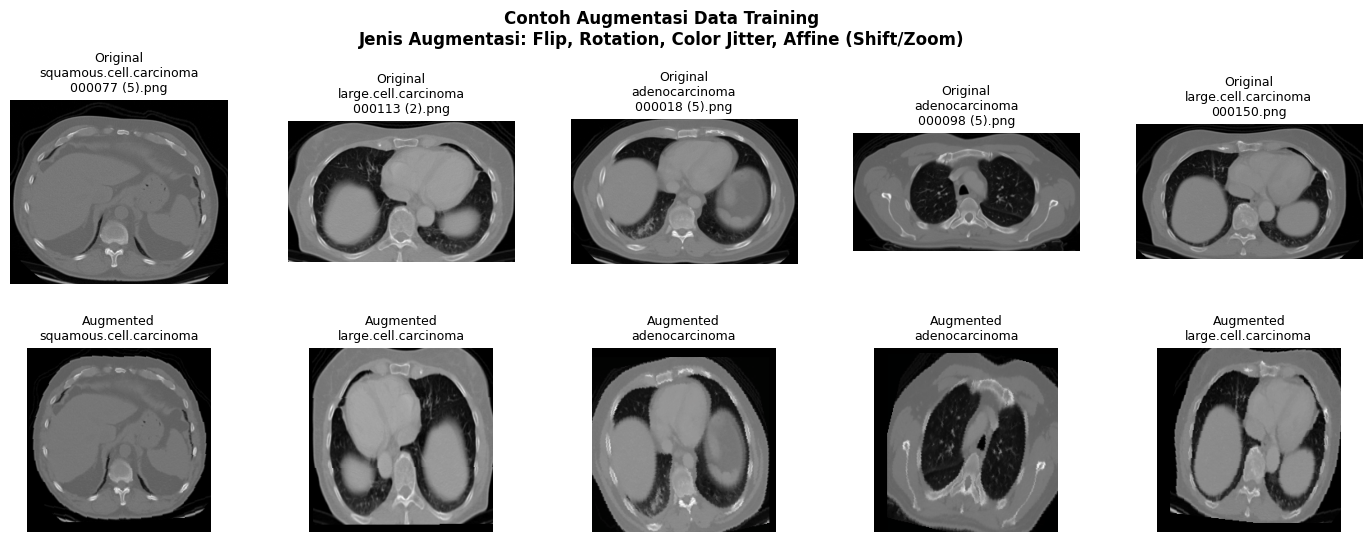

In [6]:
import matplotlib.pyplot as plt
import torch
import random  # ⬅️ tambahkan baris ini!
from torchvision import transforms
from PIL import Image

def detect_applied_augmentations(transform_pipeline):
    """Deteksi jenis augmentasi yang digunakan."""
    aug_list = []
    for t in transform_pipeline.transforms:
        name = t.__class__.__name__
        if "RandomRotation" in name:
            aug_list.append("Rotation")
        elif "RandomHorizontalFlip" in name:
            aug_list.append("Flip")
        elif "RandomAffine" in name:
            aug_list.append("Affine (Shift/Zoom)")
        elif "ColorJitter" in name:
            aug_list.append("Color Jitter")
        elif "RandomPerspective" in name:
            aug_list.append("Perspective")
        elif "RandomGrayscale" in name:
            aug_list.append("Grayscale")
        elif "RandomErasing" in name:
            aug_list.append("Erasing")
    return ", ".join(aug_list) if aug_list else "No Augmentation"


def visualize_multiple_augmentations_horizontal(dataset, num_pairs=5):
    """
    Menampilkan 5 pasangan gambar original dan hasil augmentasinya
    dengan layout horizontal: Original1 | Aug1 | Original2 | Aug2 ...
    """
    # Ambil sample acak sejumlah num_pairs
    indices = random.sample(range(len(dataset)), num_pairs)
    transform_pipeline = dataset.transform
    aug_types = detect_applied_augmentations(transform_pipeline)

    # Denormalisasi agar hasil augmentasi tampil natural
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Buat grid: 2 baris (Original + Augmented), kolom = num_pairs
    fig, axes = plt.subplots(2, num_pairs, figsize=(3.5 * num_pairs, 6))
    fig.suptitle(
        f"Contoh Augmentasi Data Training\nJenis Augmentasi: {aug_types}",
        fontsize=12, fontweight='bold'
    )

    for col, idx in enumerate(indices):
        img_path, label = dataset.samples[idx]
        class_name = list(dataset.class_to_idx.keys())[label]

        # Buka gambar original
        original_img = Image.open(img_path).convert("RGB")

        # Terapkan augmentasi
        aug_img, _ = dataset[idx]
        aug_img = inv_normalize(aug_img)
        aug_img = torch.clamp(aug_img, 0, 1).permute(1, 2, 0).numpy()

        # Baris pertama → Original
        axes[0, col].imshow(original_img)
        axes[0, col].set_title(f"Original\n{class_name}\n{img_path.split('/')[-1]}", fontsize=9)
        axes[0, col].axis("off")

        # Baris kedua → Augmented
        axes[1, col].imshow(aug_img)
        axes[1, col].set_title(f"Augmented\n{class_name}", fontsize=9)
        axes[1, col].axis("off")

    plt.subplots_adjust(wspace=0.25, hspace=0.35, top=0.83)
    plt.savefig("horizontal_augmentations.png", dpi=150, bbox_inches="tight")
    plt.show()

# 🔹 Jalankan fungsi
print("Visualisasi 5 gambar original vs hasil augmentasi (layout horizontal):")
visualize_multiple_augmentations_horizontal(train_dataset, num_pairs=5)

In [7]:
def estimate_effective_dataset_size(original_size, num_augmentations=15):
    """
    Estimasi effective dataset size dengan augmentasi.
    
    Args:
        original_size: Jumlah gambar asli
        num_augmentations: Estimasi jumlah variasi unik per gambar
    """
    effective_size = original_size * num_augmentations
    
    print("\n" + "="*70)
    print("ESTIMASI EFFECTIVE DATASET SIZE")
    print("="*70)
    print(f"Original training images    : {original_size}")
    print(f"Augmentation variations     : ~{num_augmentations}x per image")
    print(f"Effective dataset size      : ~{effective_size:,} unique variations")
    print(f"\nDengan augmentasi, model akan melihat variasi berbeda setiap epoch,")
    print(f"sehingga mengurangi overfitting meskipun dataset kecil.")

estimate_effective_dataset_size(len(train_dataset))


ESTIMASI EFFECTIVE DATASET SIZE
Original training images    : 538
Augmentation variations     : ~15x per image
Effective dataset size      : ~8,070 unique variations

Dengan augmentasi, model akan melihat variasi berbeda setiap epoch,
sehingga mengurangi overfitting meskipun dataset kecil.


# Training Model efficientformer

In [8]:
!pip install timm -q

import timm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", device)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Using device: cuda


In [9]:
EPOCHS = 50
WARMUP_EPOCHS = 5
LR_BASE = 5e-4
WEIGHT_DECAY = 1e-4
TRANSFER_STRATEGY = 'full'  
PRETRAINED = True
OUTPUT_DIR = '/kaggle/working/efficientformer'
os.makedirs(OUTPUT_DIR, exist_ok=True)

num_classes = len(train_dataset.classes)
print("Detected classes:", train_dataset.classes)

Detected classes: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    loop = tqdm(loader, desc=f"Train E{epoch}", leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        if device.type == 'cuda':
            ctx = torch.amp.autocast('cuda')
        else:
            from contextlib import nullcontext
            ctx = nullcontext()

        with ctx:
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc


def validate_one_epoch(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=f"Val E{epoch}", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)

            if device.type == 'cuda':
                ctx = torch.amp.autocast('cuda')
            else:
                from contextlib import nullcontext
                ctx = nullcontext()

            with ctx:
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc

In [11]:
import json

def train_model(model_name, train_loader, val_loader):
    print(f"\n🚀 Training model: {model_name} \n")

    model = timm.create_model(model_name, pretrained=PRETRAINED, num_classes=num_classes)
    model.to(device)

    # Atur fine-tuning strategy
    FROZEN_EXCLUDE_KEYWORDS = ['head', 'classifier', 'fc']
    if TRANSFER_STRATEGY == 'freeze_head':
        for name, p in model.named_parameters():
            p.requires_grad = False
            if any(k in name.lower() for k in FROZEN_EXCLUDE_KEYWORDS):
                p.requires_grad = True
        print("Strategy: freeze_head → hanya head/classifier yang dilatih.")
    elif TRANSFER_STRATEGY == 'partial':
        params = list(model.named_parameters())
        cutoff = int(len(params) * 0.7)
        for idx, (name, p) in enumerate(params):
            p.requires_grad = False if idx < cutoff else True
        print("Strategy: partial fine-tune → layer awal dibekukan, layer akhir dilatih.")
    else:  # full
        for p in model.parameters():
            p.requires_grad = True
        print("Strategy: full fine-tune → semua parameter dilatih.")

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = AdamW(model.parameters(), lr=LR_BASE, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS), eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, EPOCHS + 1):
        if epoch <= WARMUP_EPOCHS:
            warmup_factor = epoch / float(WARMUP_EPOCHS)
            for g in optimizer.param_groups:
                g['lr'] = LR_BASE * warmup_factor

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, epoch)
        if epoch > WARMUP_EPOCHS:
            scheduler.step()
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, epoch)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f'best_{model_name}.pth'))
            print(f"✅ Model terbaik {model_name} disimpan.")

    print(f"Training selesai untuk {model_name}. Best val_loss: {best_val_loss:.4f}\n")

    # =============== SAVE JSON HISTORY ===============
    history_path = os.path.join(OUTPUT_DIR, f"history_{model_name}.json")

    with open(history_path, "w") as f:
        json.dump(history, f, indent=4)

    print(f"📁 History training disimpan ke {history_path}")

    return history

# =============================
# 6️⃣ Jalankan Training
# =============================
hist_v1_aug = train_model('efficientformer_l3', train_loader, val_loader)
hist_v2_aug = train_model('efficientformerv2_s2', train_loader, val_loader)


🚀 Training model: efficientformer_l3 

Strategy: full fine-tune → semua parameter dilatih.


/tmp/ipykernel_165/387919163.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train E1:   0%|          | 0/16 [00:00<?, ?it/s]

Val E1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01: Train Acc=0.4219 | Val Acc=0.4161
✅ Model terbaik efficientformer_l3 disimpan.


Train E2:   0%|          | 0/16 [00:00<?, ?it/s]

Val E2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02: Train Acc=0.6523 | Val Acc=0.5985
✅ Model terbaik efficientformer_l3 disimpan.


Train E3:   0%|          | 0/16 [00:00<?, ?it/s]

Val E3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03: Train Acc=0.7812 | Val Acc=0.6642
✅ Model terbaik efficientformer_l3 disimpan.


Train E4:   0%|          | 0/16 [00:00<?, ?it/s]

Val E4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04: Train Acc=0.9082 | Val Acc=0.8759
✅ Model terbaik efficientformer_l3 disimpan.


Train E5:   0%|          | 0/16 [00:00<?, ?it/s]

Val E5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05: Train Acc=0.9238 | Val Acc=0.8321


Train E6:   0%|          | 0/16 [00:00<?, ?it/s]

Val E6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06: Train Acc=0.9590 | Val Acc=0.7737


Train E7:   0%|          | 0/16 [00:00<?, ?it/s]

Val E7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07: Train Acc=0.9492 | Val Acc=0.8905


Train E8:   0%|          | 0/16 [00:00<?, ?it/s]

Val E8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08: Train Acc=0.9570 | Val Acc=0.7518


Train E9:   0%|          | 0/16 [00:00<?, ?it/s]

Val E9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09: Train Acc=0.9785 | Val Acc=0.8540


Train E10:   0%|          | 0/16 [00:00<?, ?it/s]

Val E10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Train Acc=0.9844 | Val Acc=0.9051


Train E11:   0%|          | 0/16 [00:00<?, ?it/s]

Val E11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Train Acc=0.9727 | Val Acc=0.9197
✅ Model terbaik efficientformer_l3 disimpan.


Train E12:   0%|          | 0/16 [00:00<?, ?it/s]

Val E12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Train Acc=0.9648 | Val Acc=0.8832


Train E13:   0%|          | 0/16 [00:00<?, ?it/s]

Val E13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Train Acc=0.9883 | Val Acc=0.9051


Train E14:   0%|          | 0/16 [00:00<?, ?it/s]

Val E14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Train Acc=0.9824 | Val Acc=0.9270


Train E15:   0%|          | 0/16 [00:00<?, ?it/s]

Val E15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Train Acc=0.9883 | Val Acc=0.9416
✅ Model terbaik efficientformer_l3 disimpan.


Train E16:   0%|          | 0/16 [00:00<?, ?it/s]

Val E16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Train Acc=0.9844 | Val Acc=0.7883


Train E17:   0%|          | 0/16 [00:00<?, ?it/s]

Val E17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Train Acc=0.9766 | Val Acc=0.9197


Train E18:   0%|          | 0/16 [00:00<?, ?it/s]

Val E18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Train Acc=0.9902 | Val Acc=0.9124


Train E19:   0%|          | 0/16 [00:00<?, ?it/s]

Val E19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Train Acc=0.9922 | Val Acc=0.9489
✅ Model terbaik efficientformer_l3 disimpan.


Train E20:   0%|          | 0/16 [00:00<?, ?it/s]

Val E20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Train Acc=0.9922 | Val Acc=0.9270
✅ Model terbaik efficientformer_l3 disimpan.


Train E21:   0%|          | 0/16 [00:00<?, ?it/s]

Val E21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Train Acc=0.9941 | Val Acc=0.9343


Train E22:   0%|          | 0/16 [00:00<?, ?it/s]

Val E22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Train Acc=0.9961 | Val Acc=0.9489


Train E23:   0%|          | 0/16 [00:00<?, ?it/s]

Val E23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Train Acc=0.9941 | Val Acc=0.9489


Train E24:   0%|          | 0/16 [00:00<?, ?it/s]

Val E24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Train Acc=0.9980 | Val Acc=0.9635
✅ Model terbaik efficientformer_l3 disimpan.


Train E25:   0%|          | 0/16 [00:00<?, ?it/s]

Val E25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Train Acc=0.9980 | Val Acc=0.9635


Train E26:   0%|          | 0/16 [00:00<?, ?it/s]

Val E26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Train Acc=0.9941 | Val Acc=0.9562


Train E27:   0%|          | 0/16 [00:00<?, ?it/s]

Val E27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Train Acc=1.0000 | Val Acc=0.9635


Train E28:   0%|          | 0/16 [00:00<?, ?it/s]

Val E28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Train Acc=0.9961 | Val Acc=0.9635


Train E29:   0%|          | 0/16 [00:00<?, ?it/s]

Val E29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Train Acc=1.0000 | Val Acc=0.9635


Train E30:   0%|          | 0/16 [00:00<?, ?it/s]

Val E30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Train Acc=1.0000 | Val Acc=0.9562


Train E31:   0%|          | 0/16 [00:00<?, ?it/s]

Val E31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Train Acc=1.0000 | Val Acc=0.9635
✅ Model terbaik efficientformer_l3 disimpan.


Train E32:   0%|          | 0/16 [00:00<?, ?it/s]

Val E32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Train Acc=0.9961 | Val Acc=0.9635


Train E33:   0%|          | 0/16 [00:00<?, ?it/s]

Val E33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Train Acc=0.9941 | Val Acc=0.9635
✅ Model terbaik efficientformer_l3 disimpan.


Train E34:   0%|          | 0/16 [00:00<?, ?it/s]

Val E34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Train Acc=1.0000 | Val Acc=0.9489


Train E35:   0%|          | 0/16 [00:00<?, ?it/s]

Val E35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Train Acc=0.9980 | Val Acc=0.9416


Train E36:   0%|          | 0/16 [00:00<?, ?it/s]

Val E36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Train Acc=0.9961 | Val Acc=0.9562


Train E37:   0%|          | 0/16 [00:00<?, ?it/s]

Val E37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Train Acc=0.9941 | Val Acc=0.9562


Train E38:   0%|          | 0/16 [00:00<?, ?it/s]

Val E38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Train Acc=1.0000 | Val Acc=0.9489


Train E39:   0%|          | 0/16 [00:00<?, ?it/s]

Val E39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Train Acc=0.9980 | Val Acc=0.9489


Train E40:   0%|          | 0/16 [00:00<?, ?it/s]

Val E40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Train Acc=0.9980 | Val Acc=0.9489


Train E41:   0%|          | 0/16 [00:00<?, ?it/s]

Val E41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Train Acc=0.9922 | Val Acc=0.9562


Train E42:   0%|          | 0/16 [00:00<?, ?it/s]

Val E42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Train Acc=1.0000 | Val Acc=0.9562


Train E43:   0%|          | 0/16 [00:00<?, ?it/s]

Val E43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Train Acc=0.9980 | Val Acc=0.9489


Train E44:   0%|          | 0/16 [00:00<?, ?it/s]

Val E44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Train Acc=0.9961 | Val Acc=0.9562


Train E45:   0%|          | 0/16 [00:00<?, ?it/s]

Val E45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Train Acc=0.9980 | Val Acc=0.9635


Train E46:   0%|          | 0/16 [00:00<?, ?it/s]

Val E46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Train Acc=0.9961 | Val Acc=0.9562


Train E47:   0%|          | 0/16 [00:00<?, ?it/s]

Val E47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Train Acc=0.9980 | Val Acc=0.9635


Train E48:   0%|          | 0/16 [00:00<?, ?it/s]

Val E48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Train Acc=1.0000 | Val Acc=0.9562


Train E49:   0%|          | 0/16 [00:00<?, ?it/s]

Val E49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Train Acc=0.9941 | Val Acc=0.9489


Train E50:   0%|          | 0/16 [00:00<?, ?it/s]

Val E50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: Train Acc=0.9980 | Val Acc=0.9562
Training selesai untuk efficientformer_l3. Best val_loss: 0.1905

📁 History training disimpan ke /kaggle/working/efficientformer/history_efficientformer_l3.json

🚀 Training model: efficientformerv2_s2 



model.safetensors:   0%|          | 0.00/51.4M [00:00<?, ?B/s]

Strategy: full fine-tune → semua parameter dilatih.


/tmp/ipykernel_165/387919163.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train E1:   0%|          | 0/16 [00:00<?, ?it/s]

Val E1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01: Train Acc=0.4082 | Val Acc=0.3139
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E2:   0%|          | 0/16 [00:00<?, ?it/s]

Val E2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02: Train Acc=0.5742 | Val Acc=0.4672


Train E3:   0%|          | 0/16 [00:00<?, ?it/s]

Val E3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03: Train Acc=0.6895 | Val Acc=0.6350


Train E4:   0%|          | 0/16 [00:00<?, ?it/s]

Val E4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04: Train Acc=0.8516 | Val Acc=0.7226


Train E5:   0%|          | 0/16 [00:00<?, ?it/s]

Val E5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05: Train Acc=0.8730 | Val Acc=0.6131


Train E6:   0%|          | 0/16 [00:00<?, ?it/s]

Val E6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06: Train Acc=0.8926 | Val Acc=0.8394


Train E7:   0%|          | 0/16 [00:00<?, ?it/s]

Val E7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07: Train Acc=0.9141 | Val Acc=0.8467


Train E8:   0%|          | 0/16 [00:00<?, ?it/s]

Val E8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08: Train Acc=0.9453 | Val Acc=0.8540
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E9:   0%|          | 0/16 [00:00<?, ?it/s]

Val E9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09: Train Acc=0.9297 | Val Acc=0.8686


Train E10:   0%|          | 0/16 [00:00<?, ?it/s]

Val E10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Train Acc=0.9590 | Val Acc=0.8321
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E11:   0%|          | 0/16 [00:00<?, ?it/s]

Val E11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Train Acc=0.9766 | Val Acc=0.8978
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E12:   0%|          | 0/16 [00:00<?, ?it/s]

Val E12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Train Acc=0.9805 | Val Acc=0.9635
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E13:   0%|          | 0/16 [00:00<?, ?it/s]

Val E13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Train Acc=0.9590 | Val Acc=0.7810


Train E14:   0%|          | 0/16 [00:00<?, ?it/s]

Val E14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Train Acc=0.9746 | Val Acc=0.9635
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E15:   0%|          | 0/16 [00:00<?, ?it/s]

Val E15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Train Acc=0.9863 | Val Acc=0.9416


Train E16:   0%|          | 0/16 [00:00<?, ?it/s]

Val E16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Train Acc=0.9883 | Val Acc=0.9416


Train E17:   0%|          | 0/16 [00:00<?, ?it/s]

Val E17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Train Acc=0.9844 | Val Acc=0.8905


Train E18:   0%|          | 0/16 [00:00<?, ?it/s]

Val E18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Train Acc=0.9824 | Val Acc=0.9270


Train E19:   0%|          | 0/16 [00:00<?, ?it/s]

Val E19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Train Acc=0.9902 | Val Acc=0.9124


Train E20:   0%|          | 0/16 [00:00<?, ?it/s]

Val E20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Train Acc=0.9863 | Val Acc=0.9343


Train E21:   0%|          | 0/16 [00:00<?, ?it/s]

Val E21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Train Acc=0.9863 | Val Acc=0.9197


Train E22:   0%|          | 0/16 [00:00<?, ?it/s]

Val E22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Train Acc=0.9863 | Val Acc=0.9343


Train E23:   0%|          | 0/16 [00:00<?, ?it/s]

Val E23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Train Acc=0.9883 | Val Acc=0.9562
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E24:   0%|          | 0/16 [00:00<?, ?it/s]

Val E24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Train Acc=0.9824 | Val Acc=0.9416


Train E25:   0%|          | 0/16 [00:00<?, ?it/s]

Val E25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Train Acc=0.9941 | Val Acc=0.9489
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E26:   0%|          | 0/16 [00:00<?, ?it/s]

Val E26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Train Acc=0.9922 | Val Acc=0.9635
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E27:   0%|          | 0/16 [00:00<?, ?it/s]

Val E27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Train Acc=0.9863 | Val Acc=0.9562
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E28:   0%|          | 0/16 [00:00<?, ?it/s]

Val E28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Train Acc=0.9902 | Val Acc=0.9635


Train E29:   0%|          | 0/16 [00:00<?, ?it/s]

Val E29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Train Acc=0.9941 | Val Acc=0.9708


Train E30:   0%|          | 0/16 [00:00<?, ?it/s]

Val E30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Train Acc=1.0000 | Val Acc=0.9781
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E31:   0%|          | 0/16 [00:00<?, ?it/s]

Val E31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Train Acc=0.9961 | Val Acc=0.9781


Train E32:   0%|          | 0/16 [00:00<?, ?it/s]

Val E32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Train Acc=0.9980 | Val Acc=0.9781


Train E33:   0%|          | 0/16 [00:00<?, ?it/s]

Val E33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Train Acc=0.9961 | Val Acc=0.9781


Train E34:   0%|          | 0/16 [00:00<?, ?it/s]

Val E34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Train Acc=0.9941 | Val Acc=0.9781


Train E35:   0%|          | 0/16 [00:00<?, ?it/s]

Val E35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Train Acc=0.9980 | Val Acc=0.9781


Train E36:   0%|          | 0/16 [00:00<?, ?it/s]

Val E36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Train Acc=0.9941 | Val Acc=0.9781


Train E37:   0%|          | 0/16 [00:00<?, ?it/s]

Val E37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Train Acc=0.9961 | Val Acc=0.9781
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E38:   0%|          | 0/16 [00:00<?, ?it/s]

Val E38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Train Acc=0.9980 | Val Acc=0.9781
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E39:   0%|          | 0/16 [00:00<?, ?it/s]

Val E39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Train Acc=0.9980 | Val Acc=0.9781


Train E40:   0%|          | 0/16 [00:00<?, ?it/s]

Val E40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Train Acc=0.9961 | Val Acc=0.9781


Train E41:   0%|          | 0/16 [00:00<?, ?it/s]

Val E41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Train Acc=0.9980 | Val Acc=0.9781


Train E42:   0%|          | 0/16 [00:00<?, ?it/s]

Val E42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Train Acc=0.9961 | Val Acc=0.9781


Train E43:   0%|          | 0/16 [00:00<?, ?it/s]

Val E43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Train Acc=0.9961 | Val Acc=0.9781


Train E44:   0%|          | 0/16 [00:00<?, ?it/s]

Val E44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Train Acc=1.0000 | Val Acc=0.9781


Train E45:   0%|          | 0/16 [00:00<?, ?it/s]

Val E45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Train Acc=0.9980 | Val Acc=0.9781


Train E46:   0%|          | 0/16 [00:00<?, ?it/s]

Val E46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Train Acc=0.9961 | Val Acc=0.9781


Train E47:   0%|          | 0/16 [00:00<?, ?it/s]

Val E47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Train Acc=0.9961 | Val Acc=0.9781


Train E48:   0%|          | 0/16 [00:00<?, ?it/s]

Val E48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Train Acc=0.9961 | Val Acc=0.9781


Train E49:   0%|          | 0/16 [00:00<?, ?it/s]

Val E49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Train Acc=0.9961 | Val Acc=0.9781


Train E50:   0%|          | 0/16 [00:00<?, ?it/s]

Val E50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: Train Acc=0.9922 | Val Acc=0.9781
Training selesai untuk efficientformerv2_s2. Best val_loss: 0.1141

📁 History training disimpan ke /kaggle/working/efficientformer/history_efficientformerv2_s2.json


# CNN konvensional (ResNet & DenseNet)

In [12]:
# ================================================================
# TRAINING MODEL: RESNET50 ( Full 50 Epoch)
# ================================================================
import os, torch
import timm
import torch.nn as nn
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import json

OUTPUT_DIR_RESNET = '/kaggle/working/resnet50'
os.makedirs(OUTPUT_DIR_RESNET, exist_ok=True)

MODEL_NAME = 'resnet50'
num_classes = len(train_dataset.classes)

model_resnet = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)

# Partial fine-tuning (bekukan 70% layer awal)
params = list(model_resnet.named_parameters())
cutoff = int(len(params) * 0.7)
for idx, (name, p) in enumerate(params):
    p.requires_grad = False if idx < cutoff else True

model_resnet = model_resnet.to(device)

# Loss, optimizer, scheduler
criterion_resnet = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_resnet = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_resnet.parameters()),
    lr=LR_BASE, weight_decay=1e-4
)

# Scheduler cosine annealing
cosine_scheduler = CosineAnnealingLR(
    optimizer_resnet, 
    T_max=max(1, EPOCHS - WARMUP_EPOCHS), 
    eta_min=1e-6
)

# Mixed precision scaler (penting untuk GPU Ampere dan atasnya)
scaler = torch.cuda.amp.GradScaler()

# Tracking training
best_val_loss = float('inf')
history_resnet = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    # Warm-up learning rate
    if epoch <= WARMUP_EPOCHS:
        warmup_factor = epoch / float(WARMUP_EPOCHS)
        for g in optimizer_resnet.param_groups:
            g['lr'] = LR_BASE * warmup_factor

    # Training & validation per epoch
    train_loss, train_acc = train_one_epoch(
        model_resnet, train_loader, optimizer_resnet, 
        criterion_resnet, device, scaler, epoch
    )

    if epoch > WARMUP_EPOCHS:
        cosine_scheduler.step()

    val_loss, val_acc = validate_one_epoch(
        model_resnet, val_loader, criterion_resnet, device, epoch
    )

    # Logging
    history_resnet['train_loss'].append(train_loss)
    history_resnet['train_acc'].append(train_acc)
    history_resnet['val_loss'].append(val_loss)
    history_resnet['val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} → Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Simpan model terbaik berdasarkan val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_resnet.state_dict(),
            'optimizer_state_dict': optimizer_resnet.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'class_to_idx': train_dataset.class_to_idx
        }, os.path.join(OUTPUT_DIR_RESNET, 'best_resnet50.pth'))
        print("  ✅ Model terbaik ResNet50 disimpan.")

print(f"\nTraining selesai ✅ (50 Epoch). Best Val Loss: {best_val_loss:.4f}")

history_path = os.path.join(OUTPUT_DIR_RESNET, "history_resnet50.json")

with open(history_path, "w") as f:
    json.dump(history_resnet, f, indent=4)

print(f"\n📁 History training ResNet50 disimpan di: {history_path}")

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/tmp/ipykernel_165/2718017006.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train E1:   0%|          | 0/16 [00:00<?, ?it/s]

Val E1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01/50 → Train Acc: 0.2656 | Val Acc: 0.3139
  ✅ Model terbaik ResNet50 disimpan.


Train E2:   0%|          | 0/16 [00:00<?, ?it/s]

Val E2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02/50 → Train Acc: 0.4570 | Val Acc: 0.3431
  ✅ Model terbaik ResNet50 disimpan.


Train E3:   0%|          | 0/16 [00:00<?, ?it/s]

Val E3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03/50 → Train Acc: 0.5039 | Val Acc: 0.4088
  ✅ Model terbaik ResNet50 disimpan.


Train E4:   0%|          | 0/16 [00:00<?, ?it/s]

Val E4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04/50 → Train Acc: 0.5840 | Val Acc: 0.4745
  ✅ Model terbaik ResNet50 disimpan.


Train E5:   0%|          | 0/16 [00:00<?, ?it/s]

Val E5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05/50 → Train Acc: 0.6152 | Val Acc: 0.4964
  ✅ Model terbaik ResNet50 disimpan.


Train E6:   0%|          | 0/16 [00:00<?, ?it/s]

Val E6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06/50 → Train Acc: 0.6328 | Val Acc: 0.5766
  ✅ Model terbaik ResNet50 disimpan.


Train E7:   0%|          | 0/16 [00:00<?, ?it/s]

Val E7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07/50 → Train Acc: 0.6953 | Val Acc: 0.5912
  ✅ Model terbaik ResNet50 disimpan.


Train E8:   0%|          | 0/16 [00:00<?, ?it/s]

Val E8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08/50 → Train Acc: 0.7480 | Val Acc: 0.5985
  ✅ Model terbaik ResNet50 disimpan.


Train E9:   0%|          | 0/16 [00:00<?, ?it/s]

Val E9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09/50 → Train Acc: 0.8047 | Val Acc: 0.7226
  ✅ Model terbaik ResNet50 disimpan.


Train E10:   0%|          | 0/16 [00:00<?, ?it/s]

Val E10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/50 → Train Acc: 0.8672 | Val Acc: 0.7226


Train E11:   0%|          | 0/16 [00:00<?, ?it/s]

Val E11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/50 → Train Acc: 0.8867 | Val Acc: 0.7445
  ✅ Model terbaik ResNet50 disimpan.


Train E12:   0%|          | 0/16 [00:00<?, ?it/s]

Val E12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/50 → Train Acc: 0.9219 | Val Acc: 0.7737
  ✅ Model terbaik ResNet50 disimpan.


Train E13:   0%|          | 0/16 [00:00<?, ?it/s]

Val E13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/50 → Train Acc: 0.9180 | Val Acc: 0.7664


Train E14:   0%|          | 0/16 [00:00<?, ?it/s]

Val E14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/50 → Train Acc: 0.9004 | Val Acc: 0.8394
  ✅ Model terbaik ResNet50 disimpan.


Train E15:   0%|          | 0/16 [00:00<?, ?it/s]

Val E15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/50 → Train Acc: 0.9336 | Val Acc: 0.8686
  ✅ Model terbaik ResNet50 disimpan.


Train E16:   0%|          | 0/16 [00:00<?, ?it/s]

Val E16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/50 → Train Acc: 0.9316 | Val Acc: 0.8394


Train E17:   0%|          | 0/16 [00:00<?, ?it/s]

Val E17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/50 → Train Acc: 0.9473 | Val Acc: 0.8759


Train E18:   0%|          | 0/16 [00:00<?, ?it/s]

Val E18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/50 → Train Acc: 0.9629 | Val Acc: 0.8686


Train E19:   0%|          | 0/16 [00:00<?, ?it/s]

Val E19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/50 → Train Acc: 0.9570 | Val Acc: 0.8686


Train E20:   0%|          | 0/16 [00:00<?, ?it/s]

Val E20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/50 → Train Acc: 0.9766 | Val Acc: 0.8905
  ✅ Model terbaik ResNet50 disimpan.


Train E21:   0%|          | 0/16 [00:00<?, ?it/s]

Val E21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/50 → Train Acc: 0.9629 | Val Acc: 0.8686


Train E22:   0%|          | 0/16 [00:00<?, ?it/s]

Val E22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/50 → Train Acc: 0.9531 | Val Acc: 0.8832


Train E23:   0%|          | 0/16 [00:00<?, ?it/s]

Val E23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/50 → Train Acc: 0.9668 | Val Acc: 0.8832


Train E24:   0%|          | 0/16 [00:00<?, ?it/s]

Val E24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/50 → Train Acc: 0.9648 | Val Acc: 0.8613


Train E25:   0%|          | 0/16 [00:00<?, ?it/s]

Val E25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/50 → Train Acc: 0.9727 | Val Acc: 0.8978
  ✅ Model terbaik ResNet50 disimpan.


Train E26:   0%|          | 0/16 [00:00<?, ?it/s]

Val E26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/50 → Train Acc: 0.9746 | Val Acc: 0.9124
  ✅ Model terbaik ResNet50 disimpan.


Train E27:   0%|          | 0/16 [00:00<?, ?it/s]

Val E27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/50 → Train Acc: 0.9785 | Val Acc: 0.9051


Train E28:   0%|          | 0/16 [00:00<?, ?it/s]

Val E28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/50 → Train Acc: 0.9844 | Val Acc: 0.8759


Train E29:   0%|          | 0/16 [00:00<?, ?it/s]

Val E29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/50 → Train Acc: 0.9746 | Val Acc: 0.8759


Train E30:   0%|          | 0/16 [00:00<?, ?it/s]

Val E30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/50 → Train Acc: 0.9902 | Val Acc: 0.9124


Train E31:   0%|          | 0/16 [00:00<?, ?it/s]

Val E31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/50 → Train Acc: 0.9746 | Val Acc: 0.8905


Train E32:   0%|          | 0/16 [00:00<?, ?it/s]

Val E32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/50 → Train Acc: 0.9863 | Val Acc: 0.9343


Train E33:   0%|          | 0/16 [00:00<?, ?it/s]

Val E33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/50 → Train Acc: 0.9902 | Val Acc: 0.9343


Train E34:   0%|          | 0/16 [00:00<?, ?it/s]

Val E34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/50 → Train Acc: 0.9805 | Val Acc: 0.9416


Train E35:   0%|          | 0/16 [00:00<?, ?it/s]

Val E35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/50 → Train Acc: 0.9961 | Val Acc: 0.9343


Train E36:   0%|          | 0/16 [00:00<?, ?it/s]

Val E36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/50 → Train Acc: 0.9805 | Val Acc: 0.9416


Train E37:   0%|          | 0/16 [00:00<?, ?it/s]

Val E37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/50 → Train Acc: 0.9922 | Val Acc: 0.9343


Train E38:   0%|          | 0/16 [00:00<?, ?it/s]

Val E38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/50 → Train Acc: 0.9883 | Val Acc: 0.9270


Train E39:   0%|          | 0/16 [00:00<?, ?it/s]

Val E39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/50 → Train Acc: 0.9902 | Val Acc: 0.9343


Train E40:   0%|          | 0/16 [00:00<?, ?it/s]

Val E40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/50 → Train Acc: 0.9863 | Val Acc: 0.9270


Train E41:   0%|          | 0/16 [00:00<?, ?it/s]

Val E41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/50 → Train Acc: 0.9824 | Val Acc: 0.9270


Train E42:   0%|          | 0/16 [00:00<?, ?it/s]

Val E42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/50 → Train Acc: 0.9844 | Val Acc: 0.9270


Train E43:   0%|          | 0/16 [00:00<?, ?it/s]

Val E43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/50 → Train Acc: 0.9922 | Val Acc: 0.9343


Train E44:   0%|          | 0/16 [00:00<?, ?it/s]

Val E44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/50 → Train Acc: 0.9902 | Val Acc: 0.9197


Train E45:   0%|          | 0/16 [00:00<?, ?it/s]

Val E45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/50 → Train Acc: 0.9883 | Val Acc: 0.9343


Train E46:   0%|          | 0/16 [00:00<?, ?it/s]

Val E46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/50 → Train Acc: 0.9883 | Val Acc: 0.9416


Train E47:   0%|          | 0/16 [00:00<?, ?it/s]

Val E47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/50 → Train Acc: 0.9922 | Val Acc: 0.9343


Train E48:   0%|          | 0/16 [00:00<?, ?it/s]

Val E48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/50 → Train Acc: 0.9785 | Val Acc: 0.9343


Train E49:   0%|          | 0/16 [00:00<?, ?it/s]

Val E49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/50 → Train Acc: 0.9922 | Val Acc: 0.9270


Train E50:   0%|          | 0/16 [00:00<?, ?it/s]

Val E50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/50 → Train Acc: 0.9980 | Val Acc: 0.9343

Training selesai ✅ (50 Epoch). Best Val Loss: 0.3037

📁 History training ResNet50 disimpan di: /kaggle/working/resnet50/history_resnet50.json


In [17]:
# ================================================================
# TRAINING MODEL: DENSENET121-SE ( Full 50 Epoch)
# ================================================================

import json
import torch
import torch.nn as nn
from timm.models.densenet import densenet121
import os
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(x)
        return x * w


class DenseNet_SE(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = densenet121(pretrained=True)
        self.features = base.features
        self.se = SEBlock(1024)
        self.classifier = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.classes)
model_densenet = DenseNet_SE(num_classes=num_classes).to(device)

criterion_dense = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_dense = torch.optim.AdamW(model_densenet.parameters(), lr=LR_BASE, weight_decay=1e-4)

# Cosine annealing scheduler
cosine_scheduler = CosineAnnealingLR(
    optimizer_dense,
    T_max=max(1, EPOCHS - WARMUP_EPOCHS),
    eta_min=1e-6
)

# Mixed precision scaler
scaler = torch.amp.GradScaler('cuda')

# Direktori output
OUTPUT_DIR_DENSENET = '/kaggle/working/densenet121_training'
os.makedirs(OUTPUT_DIR_DENSENET, exist_ok=True)

# Tracking metric
best_val_loss = float('inf')
history_dense = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"\n================ TRAINING DenseNet121-SE (50 Epoch) ================\n")

for epoch in range(1, EPOCHS + 1):
    # Warm-up learning rate
    if epoch <= WARMUP_EPOCHS:
        warmup_factor = epoch / float(WARMUP_EPOCHS)
        for g in optimizer_dense.param_groups:
            g['lr'] = LR_BASE * warmup_factor

    # Training per epoch
    train_loss, train_acc = train_one_epoch(
        model_densenet, train_loader, optimizer_dense, 
        criterion_dense, device, scaler, epoch
    )

    if epoch > WARMUP_EPOCHS:
        cosine_scheduler.step()

    # Validation per epoch
    val_out = validate_one_epoch(model_densenet, val_loader, criterion_dense, device, epoch)
    if isinstance(val_out, tuple) and len(val_out) == 2:
        val_loss, val_acc = val_out
    else:
        val_loss, val_acc, _, _ = val_out


    # Simpan ke riwayat
    history_dense['train_loss'].append(train_loss)
    history_dense['train_acc'].append(train_acc)
    history_dense['val_loss'].append(val_loss)
    history_dense['val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} → Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Simpan model terbaik berdasarkan val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_densenet.state_dict(),
            'optimizer_state_dict': optimizer_dense.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'class_to_idx': train_dataset.class_to_idx
        }, os.path.join(OUTPUT_DIR_DENSENET, 'best_densenet121.pth'))
        print("  ✅ Model terbaik DenseNet121-SE disimpan.")

print(f"\nTraining selesai ✅ (50 Epoch). Best val_loss: {best_val_loss:.4f}")

history_path = os.path.join(OUTPUT_DIR_DENSENET, "history_densenet121_se.json")

with open(history_path, "w") as f:
    json.dump(history_dense, f, indent=4)

print(f"\n📁 History training DenseNet121-SE disimpan di: {history_path}")

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]


================ TRAINING DenseNet121-SE (50 Epoch) ================



Train E1:   0%|          | 0/16 [00:00<?, ?it/s]

Val E1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01/50 → Train Acc: 0.4492 | Val Acc: 0.4964
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E2:   0%|          | 0/16 [00:00<?, ?it/s]

Val E2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02/50 → Train Acc: 0.6055 | Val Acc: 0.4599
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E3:   0%|          | 0/16 [00:00<?, ?it/s]

Val E3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03/50 → Train Acc: 0.7012 | Val Acc: 0.6934
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E4:   0%|          | 0/16 [00:00<?, ?it/s]

Val E4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04/50 → Train Acc: 0.8516 | Val Acc: 0.8686
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E5:   0%|          | 0/16 [00:00<?, ?it/s]

Val E5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05/50 → Train Acc: 0.9062 | Val Acc: 0.7883


Train E6:   0%|          | 0/16 [00:00<?, ?it/s]

Val E6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06/50 → Train Acc: 0.9277 | Val Acc: 0.8321


Train E7:   0%|          | 0/16 [00:00<?, ?it/s]

Val E7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07/50 → Train Acc: 0.9180 | Val Acc: 0.8248


Train E8:   0%|          | 0/16 [00:00<?, ?it/s]

Val E8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08/50 → Train Acc: 0.9277 | Val Acc: 0.8905
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E9:   0%|          | 0/16 [00:00<?, ?it/s]

Val E9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09/50 → Train Acc: 0.9551 | Val Acc: 0.9270


Train E10:   0%|          | 0/16 [00:00<?, ?it/s]

Val E10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/50 → Train Acc: 0.9727 | Val Acc: 0.9416
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E11:   0%|          | 0/16 [00:00<?, ?it/s]

Val E11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/50 → Train Acc: 0.9707 | Val Acc: 0.8832


Train E12:   0%|          | 0/16 [00:00<?, ?it/s]

Val E12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/50 → Train Acc: 0.9629 | Val Acc: 0.9343
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E13:   0%|          | 0/16 [00:00<?, ?it/s]

Val E13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/50 → Train Acc: 0.9844 | Val Acc: 0.9416


Train E14:   0%|          | 0/16 [00:00<?, ?it/s]

Val E14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/50 → Train Acc: 0.9844 | Val Acc: 0.9416


Train E15:   0%|          | 0/16 [00:00<?, ?it/s]

Val E15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/50 → Train Acc: 0.9785 | Val Acc: 0.9051


Train E16:   0%|          | 0/16 [00:00<?, ?it/s]

Val E16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/50 → Train Acc: 0.9492 | Val Acc: 0.8613


Train E17:   0%|          | 0/16 [00:00<?, ?it/s]

Val E17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/50 → Train Acc: 0.9746 | Val Acc: 0.9197


Train E18:   0%|          | 0/16 [00:00<?, ?it/s]

Val E18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/50 → Train Acc: 0.9863 | Val Acc: 0.9781
  ✅ Model terbaik DenseNet121-SE disimpan.


Train E19:   0%|          | 0/16 [00:00<?, ?it/s]

Val E19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/50 → Train Acc: 0.9883 | Val Acc: 0.9562


Train E20:   0%|          | 0/16 [00:00<?, ?it/s]

Val E20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/50 → Train Acc: 0.9824 | Val Acc: 0.9343


Train E21:   0%|          | 0/16 [00:00<?, ?it/s]

Val E21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/50 → Train Acc: 1.0000 | Val Acc: 0.9635


Train E22:   0%|          | 0/16 [00:00<?, ?it/s]

Val E22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/50 → Train Acc: 0.9961 | Val Acc: 0.9489


Train E23:   0%|          | 0/16 [00:00<?, ?it/s]

Val E23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/50 → Train Acc: 0.9961 | Val Acc: 0.9489


Train E24:   0%|          | 0/16 [00:00<?, ?it/s]

Val E24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/50 → Train Acc: 0.9922 | Val Acc: 0.9708


Train E25:   0%|          | 0/16 [00:00<?, ?it/s]

Val E25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/50 → Train Acc: 0.9863 | Val Acc: 0.9562


Train E26:   0%|          | 0/16 [00:00<?, ?it/s]

Val E26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/50 → Train Acc: 0.9961 | Val Acc: 0.9270


Train E27:   0%|          | 0/16 [00:00<?, ?it/s]

Val E27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/50 → Train Acc: 0.9863 | Val Acc: 0.9343


Train E28:   0%|          | 0/16 [00:00<?, ?it/s]

Val E28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/50 → Train Acc: 0.9941 | Val Acc: 0.9562


Train E29:   0%|          | 0/16 [00:00<?, ?it/s]

Val E29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/50 → Train Acc: 0.9961 | Val Acc: 0.9708


Train E30:   0%|          | 0/16 [00:00<?, ?it/s]

Val E30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/50 → Train Acc: 0.9961 | Val Acc: 0.9635


Train E31:   0%|          | 0/16 [00:00<?, ?it/s]

Val E31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/50 → Train Acc: 1.0000 | Val Acc: 0.9562


Train E32:   0%|          | 0/16 [00:00<?, ?it/s]

Val E32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/50 → Train Acc: 0.9961 | Val Acc: 0.9635


Train E33:   0%|          | 0/16 [00:00<?, ?it/s]

Val E33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/50 → Train Acc: 0.9902 | Val Acc: 0.9562


Train E34:   0%|          | 0/16 [00:00<?, ?it/s]

Val E34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/50 → Train Acc: 0.9961 | Val Acc: 0.9635


Train E35:   0%|          | 0/16 [00:00<?, ?it/s]

Val E35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/50 → Train Acc: 1.0000 | Val Acc: 0.9562


Train E36:   0%|          | 0/16 [00:00<?, ?it/s]

Val E36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/50 → Train Acc: 0.9980 | Val Acc: 0.9635


Train E37:   0%|          | 0/16 [00:00<?, ?it/s]

Val E37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/50 → Train Acc: 0.9980 | Val Acc: 0.9635


Train E38:   0%|          | 0/16 [00:00<?, ?it/s]

Val E38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/50 → Train Acc: 0.9961 | Val Acc: 0.9562


Train E39:   0%|          | 0/16 [00:00<?, ?it/s]

Val E39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/50 → Train Acc: 0.9941 | Val Acc: 0.9635


Train E40:   0%|          | 0/16 [00:00<?, ?it/s]

Val E40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/50 → Train Acc: 1.0000 | Val Acc: 0.9635


Train E41:   0%|          | 0/16 [00:00<?, ?it/s]

Val E41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/50 → Train Acc: 0.9961 | Val Acc: 0.9562


Train E42:   0%|          | 0/16 [00:00<?, ?it/s]

Val E42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/50 → Train Acc: 0.9980 | Val Acc: 0.9562


Train E43:   0%|          | 0/16 [00:00<?, ?it/s]

Val E43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/50 → Train Acc: 0.9980 | Val Acc: 0.9635


Train E44:   0%|          | 0/16 [00:00<?, ?it/s]

Val E44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/50 → Train Acc: 0.9980 | Val Acc: 0.9562


Train E45:   0%|          | 0/16 [00:00<?, ?it/s]

Val E45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/50 → Train Acc: 1.0000 | Val Acc: 0.9562


Train E46:   0%|          | 0/16 [00:00<?, ?it/s]

Val E46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/50 → Train Acc: 0.9961 | Val Acc: 0.9562


Train E47:   0%|          | 0/16 [00:00<?, ?it/s]

Val E47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/50 → Train Acc: 1.0000 | Val Acc: 0.9562


Train E48:   0%|          | 0/16 [00:00<?, ?it/s]

Val E48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/50 → Train Acc: 0.9961 | Val Acc: 0.9635


Train E49:   0%|          | 0/16 [00:00<?, ?it/s]

Val E49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/50 → Train Acc: 0.9961 | Val Acc: 0.9635


Train E50:   0%|          | 0/16 [00:00<?, ?it/s]

Val E50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/50 → Train Acc: 0.9941 | Val Acc: 0.9635

Training selesai ✅ (50 Epoch). Best val_loss: 0.1421

📁 History training DenseNet121-SE disimpan di: /kaggle/working/densenet121_training/history_densenet121_se.json


# evaluasi model

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

# Path dataset test (sesuai struktur di screenshot kamu)
test_dir = Path("/kaggle/input/chest-ctscan-images/Data/test")

# Transformasi sama seperti validasi (tanpa augmentasi)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # atau ukuran input model kamu
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset dan DataLoader
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Jumlah data test: {len(test_dataset)}")
print(f"Kelas test: {test_dataset.classes}")


Jumlah data test: 315
Kelas test: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [21]:
# ================================================================
# FINAL GRAD-CAM CODE FOR 4 MODELS (EffV2, EffL3, ResNet50, DenseNet121-SE)
# ================================================================

import torch
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

os.makedirs("/kaggle/working/gradcam_results", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ================================================================
# GRAD-CAM CLASS (AMAN, ADA REMOVE HOOK)
# ================================================================
class GradCAM:
    def __init__(self, model, target_layer, device='cpu'):
        self.model = model
        self.target_layer = target_layer
        self.device = device
        self.gradients = None
        self.activations = None
        self.handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.handles.append(self.target_layer.register_forward_hook(forward_hook))

        try:
            self.handles.append(self.target_layer.register_full_backward_hook(backward_hook))
        except:
            self.handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for h in self.handles:
            try: h.remove()
            except: pass
        self.handles = []

    def generate_cam(self, input_tensor, class_idx=None, eps=1e-8):
        self.model.zero_grad()

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        target = output[0, class_idx]
        target.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        cam -= cam.min()
        cam /= (cam.max() + eps)

        return cam


# ================================================================
# AUTO FIND TARGET LAYER (LAYAR TERAKHIR YANG OUTPUTNYA 4D)
# ================================================================
def find_target_layer(model, input_size=(1,3,224,224), device='cpu'):
    model.eval()
    model.to(device)

    layer_outputs = {}

    def save_shape(name):
        def hook(m, inp, out):
            if isinstance(out, torch.Tensor):
                layer_outputs[name] = out.shape
        return hook

    handles = []
    for name, m in model.named_modules():
        handles.append(m.register_forward_hook(save_shape(name)))

    dummy = torch.randn(*input_size).to(device)
    with torch.no_grad():
        try:
            model(dummy)
        except:
            pass

    for h in handles:
        h.remove()

    # pilih layer 4D terakhir
    target_name = None
    for name, shape in layer_outputs.items():
        if len(shape) == 4:  
            target_name = name  

    if target_name is None:
        raise RuntimeError("Tidak ada layer 4D ditemukan.")

    for name, m in model.named_modules():
        if name == target_name:
            print(f"🔥 Target Layer Found: {name}  shape={layer_outputs[name]}")
            return m

    raise RuntimeError("Layer tidak ditemukan meskipun namanya ada.")


# ================================================================
# VISUALISASI GRAD-CAM
# ================================================================
def visualize_gradcam(model, target_layer, img_path, transform, class_names, device, model_name):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)

    cam_gen = GradCAM(model, target_layer, device=device)
    try:
        cam = cam_gen.generate_cam(inp)
    finally:
        cam_gen.remove_hooks()

    cam_resized = cv2.resize(cam, (224, 224))
    cam_uint8 = np.uint8(255 * cam_resized)

    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_np = np.array(img.resize((224, 224)))
    overlay = np.uint8(0.5 * heatmap + 0.5 * img_np)

    with torch.no_grad():
        pred = torch.argmax(model(inp), dim=1).item()
        pred_label = class_names[pred]

    save_path = f"/kaggle/working/gradcam_results/{model_name}.png"

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay ({pred_label})"); plt.axis("off")
    plt.suptitle(f"Grad-CAM - {model_name}", fontsize=14)
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()

    print(f"✅ Saved: {save_path}")


# ================================================================
# 🔥 LOAD ALL 4 MODELS (GANTI PATH SESUAI CHECKPOINT KAMU)
# ================================================================
import timm
from timm.models.densenet import densenet121
import torch.nn as nn

num_classes = len(test_dataset.classes)

# ------------- EfficientFormerV2-S2 ---------------
model_v2 = timm.create_model("efficientformerv2_s2", pretrained=False, num_classes=num_classes)
model_v2.load_state_dict(torch.load("/kaggle/input/inimodelpthnya/best_efficientformerv2_s2.pth",weights_only=False))
model_v2.to(device)

# ------------- EfficientFormer-L3 -----------------
model_l3 = timm.create_model("efficientformer_l3", pretrained=False, num_classes=num_classes)
model_l3.load_state_dict(torch.load("/kaggle/input/inimodelpthnya/best_efficientformer_l3.pth",weights_only=False))
model_l3.to(device)

# ------------- ResNet50 ---------------------------
model_resnet = timm.create_model("resnet50", pretrained=False, num_classes=num_classes)
model_resnet.load_state_dict(torch.load("/kaggle/input/inimodelpthnya/best_resnet50.pth",weights_only=False)["model_state_dict"])
model_resnet.to(device)

# ------------- DenseNet121-SE ---------------------
class SEBlock(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch//r, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch//r, ch, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(x)
        return x * w

class DenseNetSE(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = densenet121(pretrained=False)
        self.features = base.features
        self.se = SEBlock(1024)
        self.classifier = nn.Linear(1024, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = torch.relu(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1,1)).view(x.size(0), -1)
        return self.classifier(x)

model_dense = DenseNetSE(num_classes)
ckpt = torch.load("/kaggle/input/inimodelpthnya/best_densenet121.pth",weights_only=False)
model_dense.load_state_dict(ckpt["model_state_dict"])
model_dense.to(device)


# ================================================================
# 🔥 PILIH 1 GAMBAR RANDOM DARI TESTSET
# ================================================================
sample_img, _ = random.choice(test_dataset.samples)
print("🖼 Menggunakan gambar:", sample_img)


# ================================================================
# TARGET LAYER (AUTO-DETECT)
# ================================================================
tl_v2  = find_target_layer(model_v2, device=device)
tl_l3  = find_target_layer(model_l3, device=device)
tl_res = model_resnet.layer4[-1].conv3         # manual OK
tl_den = model_dense.features[-1]              # manual OK


# ================================================================
# 🔥 FINAL — GENERATE GRAD-CAM UNTUK 4 MODEL
# ================================================================
visualize_gradcam(model_v2,  tl_v2,  sample_img, test_transform, test_dataset.classes, device, "EfficientFormerV2-S2")
visualize_gradcam(model_l3,  tl_l3,  sample_img, test_transform, test_dataset.classes, device, "EfficientFormer-L3")
visualize_gradcam(model_resnet, tl_res, sample_img, test_transform, test_dataset.classes, device, "ResNet50")
visualize_gradcam(model_dense, tl_den, sample_img, test_transform, test_dataset.classes, device, "DenseNet121-SE")

print("\n🎉 Semua Grad-CAM tersimpan di /kaggle/working/gradcam_results/")


Device: cuda
🖼 Menggunakan gambar: /kaggle/input/chest-ctscan-images/Data/test/adenocarcinoma/000137 (2).png
🔥 Target Layer Found: norm  shape=torch.Size([1, 288, 7, 7])
🔥 Target Layer Found: stages.3.blocks.1  shape=torch.Size([1, 512, 7, 7])
✅ Saved: /kaggle/working/gradcam_results/EfficientFormerV2-S2.png
✅ Saved: /kaggle/working/gradcam_results/EfficientFormer-L3.png
✅ Saved: /kaggle/working/gradcam_results/ResNet50.png
✅ Saved: /kaggle/working/gradcam_results/DenseNet121-SE.png

🎉 Semua Grad-CAM tersimpan di /kaggle/working/gradcam_results/


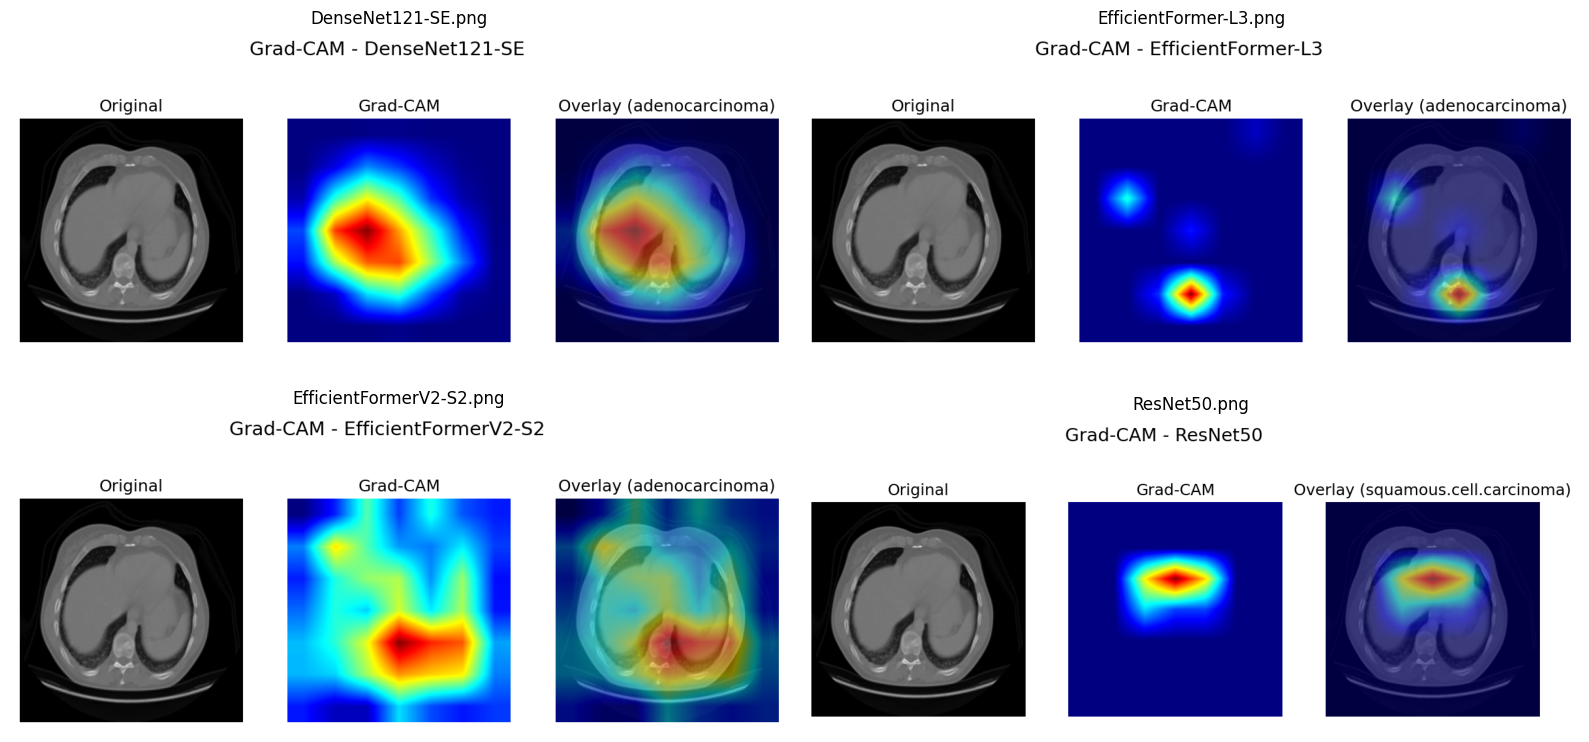

In [22]:
# ================================================================
# 📌 Tampilkan semua hasil Grad-CAM dalam 1 grid
# ================================================================
from PIL import Image
import matplotlib.pyplot as plt
import os

result_dir = "/kaggle/working/gradcam_results"
files = sorted(os.listdir(result_dir))  # ambil semua file hasil Grad-CAM

plt.figure(figsize=(16, 8))

for i, fname in enumerate(files):
    try:
        img = Image.open(os.path.join(result_dir, fname))
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(fname)
        plt.axis("off")
    except:
        pass

plt.tight_layout()
plt.show()

In [27]:
!pip install thop
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, classification_report
from thop import profile
import time
import timm
from timm.models.densenet import densenet121
import numpy as np
from tqdm.auto import tqdm

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_time, total_images = 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)

            # Hitung waktu inferensi
            start = time.time()
            outputs = model(imgs)
            end = time.time()

            total_time += (end - start)
            total_images += imgs.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    infer_time = total_time / total_images

    return acc, f1_macro, f1_weighted, infer_time, all_preds, all_labels

def load_model(model_name, num_classes, weight_path):
    model = None

    if model_name == "resnet50":
        model = timm.create_model("resnet50", pretrained=False, num_classes=num_classes)
        ckpt = torch.load(weight_path, map_location=device, weights_only=False)  # ✅ ubah di sini
        model.load_state_dict(ckpt['model_state_dict'])

    elif model_name == "efficientformer_l3":
        model = timm.create_model("efficientformer_l3", pretrained=False, num_classes=num_classes)
        state_dict = torch.load(weight_path, map_location=device, weights_only=False)
        model.load_state_dict(state_dict)

    elif model_name == "efficientformerv2_s2":
        model = timm.create_model("efficientformerv2_s2", pretrained=False, num_classes=num_classes)
        state_dict = torch.load(weight_path, map_location=device, weights_only=False)
        model.load_state_dict(state_dict)

    elif model_name == "densenet121":
        model = DenseNet_SE(num_classes=num_classes)
        ckpt = torch.load(weight_path, map_location=device, weights_only=False)
        model.load_state_dict(ckpt['model_state_dict'])

    model.to(device)
    model.eval()
    return model

from torchsummary import summary
from pathlib import Path

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

models_info = [
    {
        "name": "efficientformer_l3",
        "path": "/kaggle/working/efficientformer/best_efficientformer_l3.pth"
    },
    {
        "name": "efficientformerv2_s2",
        "path": "/kaggle/working/efficientformer/best_efficientformerv2_s2.pth"
    },
    {
        "name": "resnet50",
        "path": "/kaggle/working/resnet50/best_resnet50.pth"
    },
    {
        "name": "densenet121",
        "path": "/kaggle/working/densenet121_training/best_densenet121.pth"
    }
]

results = []

for m in models_info:
    print(f"\n================ Evaluasi {m['name']} ================\n")

    model = load_model(m["name"], len(train_dataset.classes), m["path"])

    # Hitung parameter dan FLOPs
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)

    acc, f1_macro, f1_weighted, infer_time, preds, labels = evaluate_model(model, test_loader, device)

    results.append({
        "Model": m["name"],
        "Akurasi": acc,
        "F1-Macro": f1_macro,
        "F1-Weighted": f1_weighted,
        "Params (M)": params / 1e6,
        "FLOPs (G)": flops / 1e9,
        "Infer Time (s/img)": infer_time
    })

import pandas as pd
df_results = pd.DataFrame(results)
print("\n📊 HASIL EVALUASI MODEL:\n")
display(df_results.style.format({
    "Akurasi": "{:.4f}",
    "F1-Macro": "{:.4f}",
    "F1-Weighted": "{:.4f}",
    "Params (M)": "{:.2f}",
    "FLOPs (G)": "{:.2f}",
    "Infer Time (s/img)": "{:.5f}"
}))


================ Evaluasi efficientformer_l3 ================



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


================ Evaluasi efficientformerv2_s2 ================



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


================ Evaluasi resnet50 ================



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


================ Evaluasi densenet121 ================



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


📊 HASIL EVALUASI MODEL:



,Model,Akurasi,F1-Macro,F1-Weighted,Params (M),FLOPs (G),Infer Time (s/img)
0,efficientformer_l3,0.9429,0.9471,0.9431,30.37,3.94,0.00097
1,efficientformerv2_s2,0.9429,0.9501,0.9427,12.06,1.23,0.00175
2,resnet50,0.8286,0.8462,0.8269,23.52,4.13,0.00058
3,densenet121,0.9556,0.9584,0.9556,7.01,2.83,0.00157


In [30]:
import torch
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from thop import profile
import time
import os


================ Evaluasi resnet50 ================

Accuracy: 0.8286
F1-score: 0.8269
Params: 23.52 M
FLOPs: 4.13 GFLOPs
Inference time: 3.22 detik


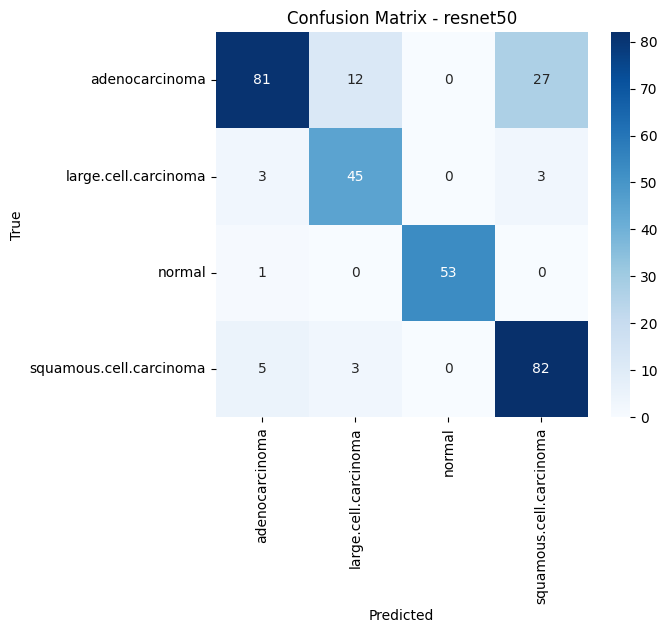


================ Evaluasi densenet121 ================

Accuracy: 0.9556
F1-score: 0.9556
Params: 7.01 M
FLOPs: 2.83 GFLOPs
Inference time: 3.00 detik


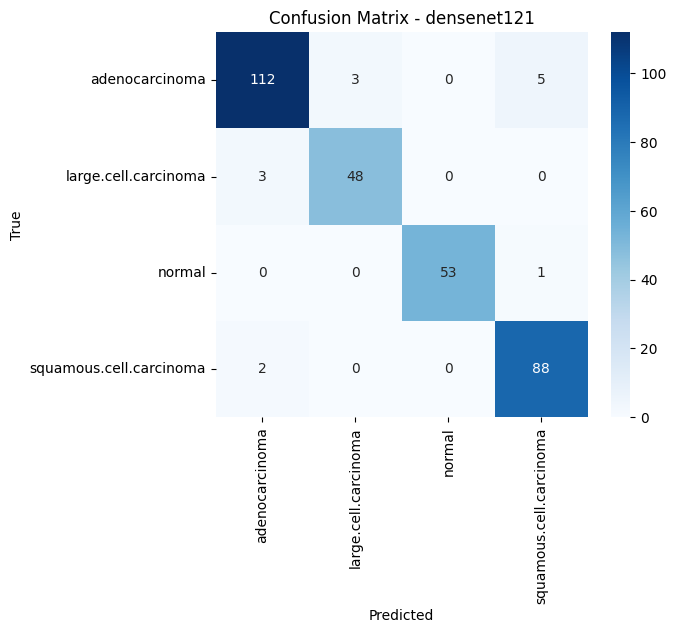


================ Evaluasi efficientformer_l3 ================

Accuracy: 0.9429
F1-score: 0.9431
Params: 30.37 M
FLOPs: 3.94 GFLOPs
Inference time: 3.37 detik


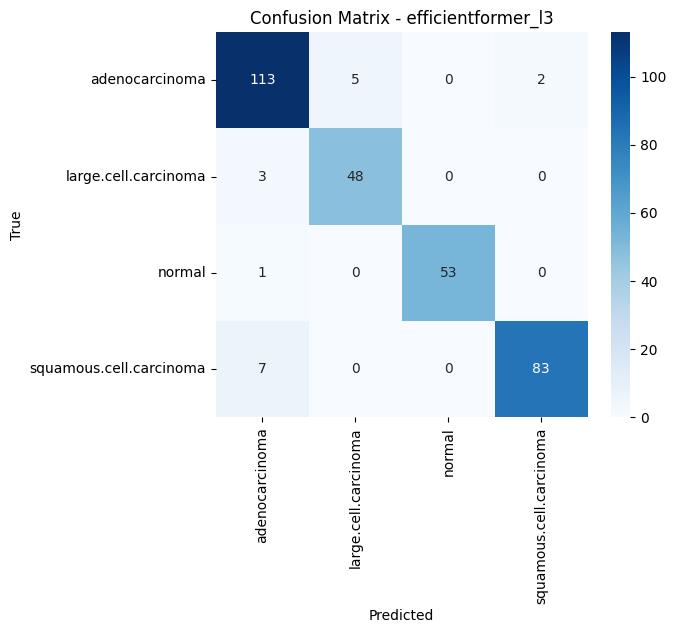


================ Evaluasi efficientformerv2_s2 ================

Accuracy: 0.9429
F1-score: 0.9427
Params: 12.06 M
FLOPs: 1.23 GFLOPs
Inference time: 3.23 detik


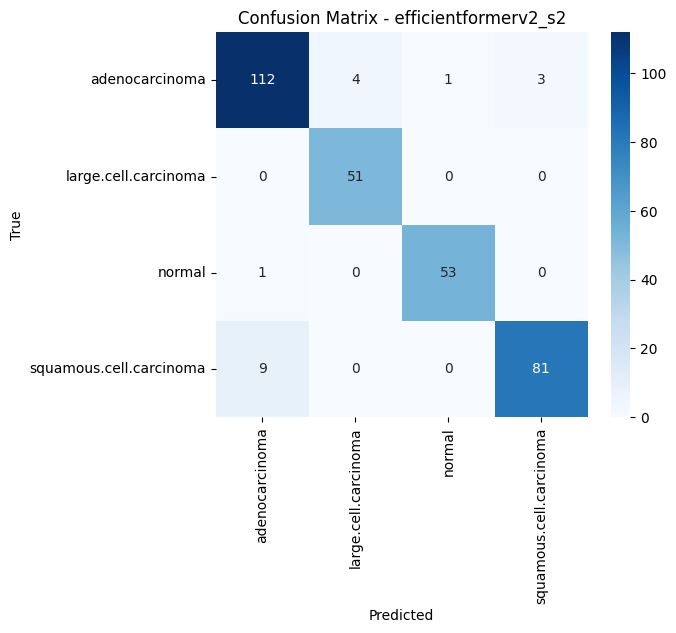

,Model,Accuracy,F1,Params (M),FLOPs (G),Inference Time (s)
0,resnet50,0.828571,0.826944,23.516228,4.131703,3.219159
1,densenet121,0.955556,0.955556,7.006468,2.833500,2.996167
2,efficientformer_l3,0.942857,0.943147,30.367176,3.939472,3.366053
3,efficientformerv2_s2,0.942857,0.942676,12.060888,1.234525,3.231928


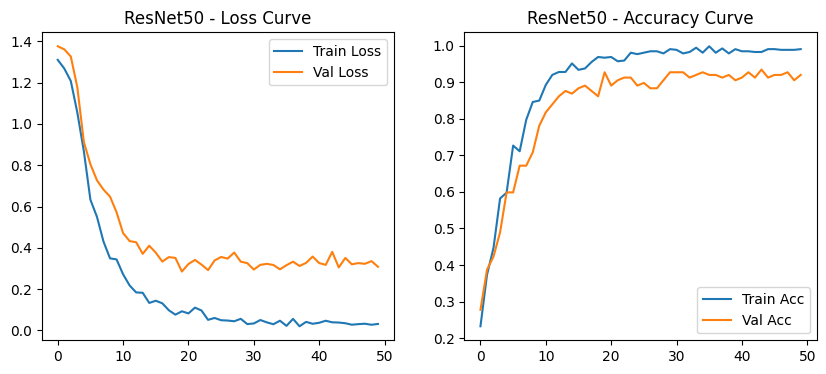

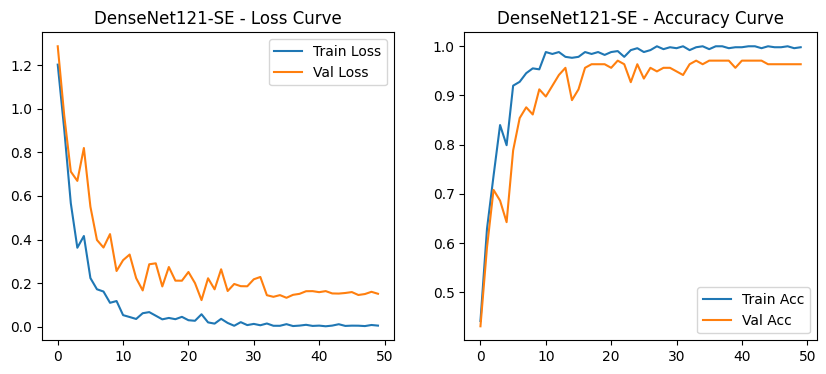

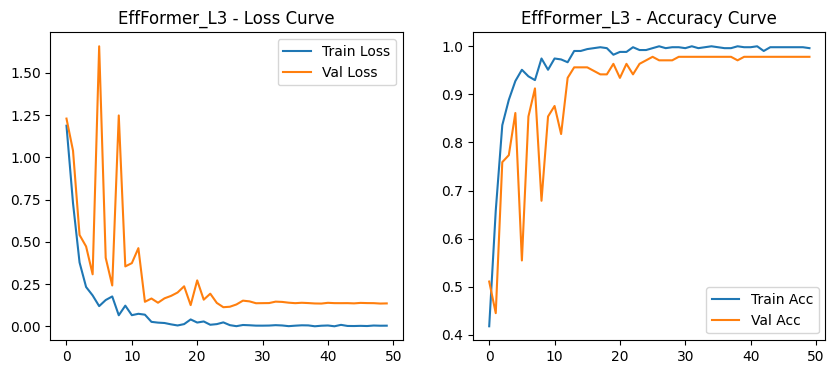

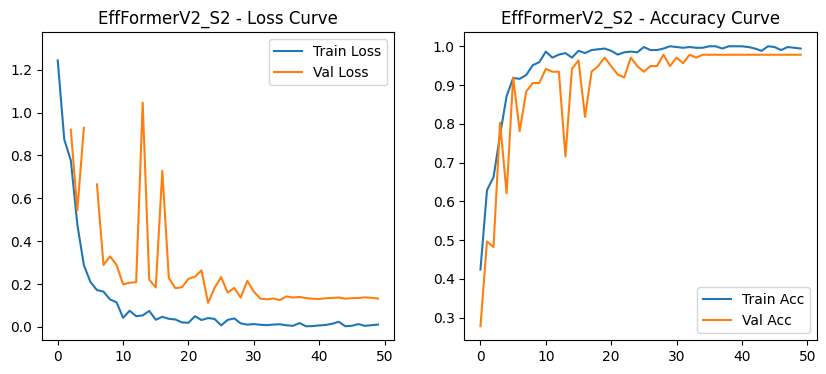

In [31]:
class SEBlock(torch.nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Conv2d(channel, channel // reduction, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(channel // reduction, channel, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(x)
        return x * w


class DenseNet_SE(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = timm.create_model("densenet121", pretrained=False, num_classes=0)
        self.features = base.features
        self.se = SEBlock(1024)
        self.classifier = torch.nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = torch.nn.functional.relu(x, inplace=True)
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.classifier(x)
        return x


# ================================================================
# FUNGSI LOAD MODEL
# ================================================================
def load_model(model_name, num_classes, weight_path):
    if model_name == "resnet50":
        model = timm.create_model("resnet50", pretrained=False, num_classes=num_classes)
        ckpt = torch.load(weight_path, map_location=device, weights_only=False)
        model.load_state_dict(ckpt['model_state_dict'])

    elif model_name == "efficientformer_l3":
        model = timm.create_model("efficientformer_l3", pretrained=False, num_classes=num_classes)
        state_dict = torch.load(weight_path, map_location=device, weights_only=False)
        model.load_state_dict(state_dict)

    elif model_name == "efficientformerv2_s2":
        model = timm.create_model("efficientformerv2_s2", pretrained=False, num_classes=num_classes)
        state_dict = torch.load(weight_path, map_location=device, weights_only=False)
        model.load_state_dict(state_dict)

    elif model_name == "densenet121":
        model = DenseNet_SE(num_classes=num_classes)
        ckpt = torch.load(weight_path, map_location=device, weights_only=False)
        model.load_state_dict(ckpt['model_state_dict'])

    model.to(device)
    model.eval()
    return model

device = "cuda" if torch.cuda.is_available() else "cpu"

models_info = [
    {"name": "resnet50", "path": "/kaggle/working/resnet50/best_resnet50.pth"},
    {"name": "densenet121", "path": "/kaggle/working/densenet121_training/best_densenet121.pth"},
    {"name": "efficientformer_l3", "path": "/kaggle/working/efficientformer/best_efficientformer_l3.pth"},
    {"name": "efficientformerv2_s2", "path": "/kaggle/working/efficientformer/best_efficientformerv2_s2.pth"},
]

results = []

for m in models_info:
    print(f"\n================ Evaluasi {m['name']} ================\n")

    model = load_model(m["name"], num_classes, m["path"])

    # ---- Hitung Parameter & FLOPs ----
    dummy = torch.randn(1, 3, 224, 224).to(device)
    flops, params = profile(model, inputs=(dummy,), verbose=False)

    # ---- Inference + Evaluasi ----
    all_preds, all_labels = [], []
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    inf_time = time.time() - start_time
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Params: {params/1e6:.2f} M")
    print(f"FLOPs: {flops/1e9:.2f} GFLOPs")
    print(f"Inference time: {inf_time:.2f} detik")

    # ---- Confusion Matrix ----
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.title(f"Confusion Matrix - {m['name']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ---- Simpan hasil ke list ----
    results.append({
        "Model": m['name'],
        "Accuracy": acc,
        "F1": f1,
        "Params (M)": params / 1e6,
        "FLOPs (G)": flops / 1e9,
        "Inference Time (s)": inf_time
    })

import pandas as pd

df_results = pd.DataFrame(results)
display(df_results)

try:
    histories = {
        "ResNet50": history_resnet,
        "DenseNet121-SE": history_dense,
        "EffFormer_L3": hist_v1_aug,
        "EffFormerV2_S2": hist_v2_aug
    }

    for name, hist in histories.items():
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(hist['train_loss'], label="Train Loss")
        plt.plot(hist['val_loss'], label="Val Loss")
        plt.title(f"{name} - Loss Curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(hist['train_acc'], label="Train Acc")
        plt.plot(hist['val_acc'], label="Val Acc")
        plt.title(f"{name} - Accuracy Curve")
        plt.legend()

        plt.show()

except Exception as e:
    print("⚠️ Tidak dapat menampilkan grafik history. Pastikan variabel history_* tersedia di notebook.")

# Implementasi Grad-CAM

In [49]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import timm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
model_paths = {
    "EfficientFormer-L3": "/kaggle/input/inimodelpthnya/best_efficientformer_l3.pth",
    "EfficientFormerV2-S2": "/kaggle/input/inimodelpthnya/best_efficientformerv2_s2.pth",
}

MODEL_NAMES = {
    "EfficientFormer-L3": "efficientformer_l3",
    "EfficientFormerV2-S2": "efficientformerv2_s2",
}

num_classes = 4
class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [51]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # hook untuk menangkap gradien dan feature map
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        # backward untuk target class
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        # hitung gradcam
        grads = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (grads * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

        # normalisasi
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam[0, 0].cpu().numpy(), class_idx

def show_gradcam_on_image(img_path, model_name, model_path):
    print(f"\n🔍 Generating Grad-CAM for {model_name}...")

    # Preprocess gambar
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Load model
    model = timm.create_model(MODEL_NAMES[model_name], pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval().to(device)

    # Tentukan target layer (ambil layer konvolusi terakhir)
    target_layer = None
    for name, module in list(model.named_modules())[::-1]:  # ✅ FIX: ubah ke list sebelum dibalik
        if isinstance(module, torch.nn.Conv2d):
            target_layer = module
            break

    if target_layer is None:
        raise ValueError("❌ Tidak ditemukan layer Conv2d di model untuk GradCAM.")

    # Inisialisasi GradCAM
    gradcam = GradCAM(model, target_layer)
    cam, class_idx = gradcam.generate(input_tensor)

    # Visualisasi
    img_np = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(heatmap, 0.5, img_np, 0.5, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"Grad-CAM Heatmap ({class_names[class_idx]})")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed)
    plt.title("Superimposed Result")
    plt.show()



🔍 Generating Grad-CAM for EfficientFormer-L3...


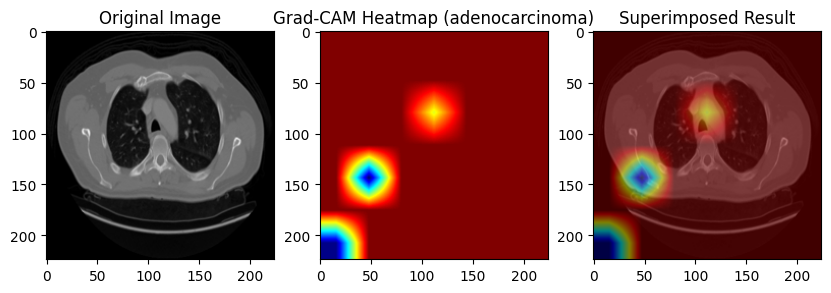


🔍 Generating Grad-CAM for EfficientFormerV2-S2...


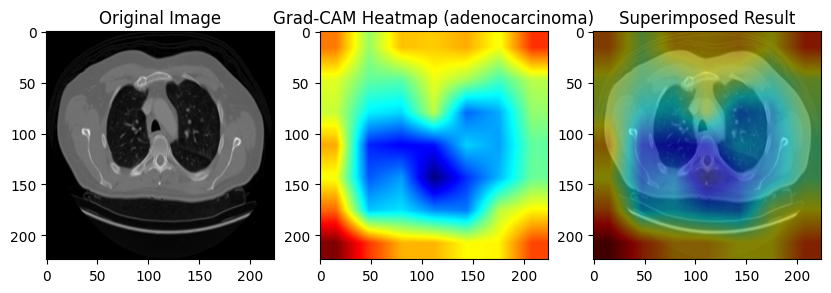

In [55]:
test_img_path = "/kaggle/input/chest-ctscan-images/Data/test/adenocarcinoma/000123 (6).png"

for model_name, model_path in model_paths.items():
    show_gradcam_on_image(test_img_path, model_name, model_path)